In [29]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import os

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [41]:
# Reading and consultation

df = pd.read_csv(r'./SEER Breast Cancer Dataset .csv', encoding='ascii')
df.head(3)

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead


In [31]:
# Drop unvalide column 'Unnamed'
df = df.drop(columns=['Unnamed: 3'])
df.columns


Index(['Age', 'Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [32]:
# Nombre de caractéristiques (colonnes) et d'échantillons (lignes)
num_features = df.shape[1]
num_samples = df.shape[0]
print("\nNombre de caractéristiques (colonnes) :", num_features)
print("Nombre d'échantillons (lignes) :", num_samples)


Nombre de caractéristiques (colonnes) : 15
Nombre d'échantillons (lignes) : 7108


In [33]:
# Distribution des statuts (Alive vs Dead)
status_distribution = df['Status'].value_counts()
print("\nDistribution des statuts :")
print(status_distribution)


Distribution des statuts :
Status
Alive     4472
Dead      2634
Status       1
Name: count, dtype: int64


In [34]:
# Spliting the Data into training Set qnd test set
# Conserving data 
dfs = df
# Nettoyage des noms des colonnes
df.columns = df.columns.str.strip()

# Get The target Status ( "Dead or Alive")
df['Status_encoded'] = df['Status'].map({'Alive': 0, 'Dead': 1})
Y = df['Status_encoded']

# Choosing features/inputs
dfs = dfs.drop(columns=['Status'])
X = df[['Age', '6th Stage', 'Tumor Size', 'Grade', 'T Stage', 'N Stage','Regional Node Examined',
        'Reginol Node Positive','Survival Months']]
# Train_Set and Test_Set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

print("Inputs :  \n", X_train.columns)
print("Target :  \n", Y_train)
print(Y_train.isnull().sum())
print(Y_test.isnull().sum())

# Supprimer les lignes correspondantes aux NaN dans Y_train
X_train = X_train[~Y_train.isnull()]
Y_train = Y_train.dropna()
# Remplacer les NaN dans Y_train par la classe majoritaire
Y_train = Y_train.fillna(Y_train.mode()[0])
print(Y_train.isnull().sum())  # Devrait afficher 0
print("this is : ",X_train.columns)  # Should show (num_samples, 9)



Inputs :  
 Index(['Age', '6th Stage', 'Tumor Size', 'Grade', 'T Stage', 'N Stage',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months'],
      dtype='object')
Target :  
 3606    0.0
794     0.0
3366    0.0
1536    0.0
1561    0.0
       ... 
3772    0.0
5191    1.0
5226    0.0
5390    0.0
860     1.0
Name: Status_encoded, Length: 5686, dtype: float64
2
0
0
this is :  Index(['Age', '6th Stage', 'Tumor Size', 'Grade', 'T Stage', 'N Stage',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months'],
      dtype='object')


In [35]:

# Fitting Models and getting the best one
def train_and_evaluate_models(X_Train, X_Test, Y_Train, Y_Test):
    # Identify numeric and categorical columns
    numeric_features = X_Train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_Train.select_dtypes(include=['object']).columns

    # Preprocessing for numeric data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(random_state=42)
    }

    results = {}
    for model_name, model in models.items():
        # Create a pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Train the model
        pipeline.fit(X_Train, Y_Train)
        
        # Make predictions
        y_pred = pipeline.predict(X_Test)
        
        # Evaluate model
        accuracy = accuracy_score(Y_Test, y_pred)
        cm = confusion_matrix(Y_Test, y_pred)
        cr = classification_report(Y_Test, y_pred)
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': cr
        }

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy:.4f}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        print(f"\nClassification Report for {model_name}:")
        print(cr)

    return results

# Train and evaluate models

# results = train_and_evaluate_models(X_train, X_test, Y_train, Y_test)

# Function to find the best model
def get_best_model(results):
    best_accuracy = 0
    best_model_name = None
    
    for name, result in results.items():
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model_name = name
    
    return best_model_name, best_accuracy

# Get the best model
# best_model_name, best_accuracy = get_best_model(results)
# print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")

In [36]:
def save_model_components(pipeline, best_model_name):
    """
    Save the best model pipeline, its components, and metadata.
    
    Args:
        pipeline (Pipeline): The trained pipeline containing preprocessing and model.
        best_model_name (str): The name of the best model.
    """
    # Create a directory for saving if it doesn't exist
    if not os.path.exists('model'):
        os.makedirs('model')
    
    # Save the entire pipeline (preprocessor + model)
    joblib.dump(pipeline, 'model/best_pipeline.pkl')
    
    # Save model name
    with open('model/model_info.txt', 'w') as f:
        f.write(f"Best Model: {best_model_name}")
    
    print(f"Pipeline and model metadata saved successfully. Best model: {best_model_name}")


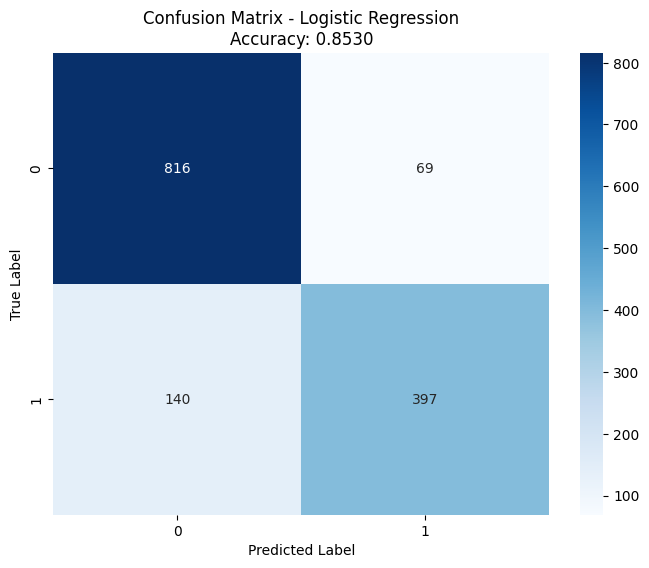


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.89       885
         1.0       0.85      0.74      0.79       537

    accuracy                           0.85      1422
   macro avg       0.85      0.83      0.84      1422
weighted avg       0.85      0.85      0.85      1422



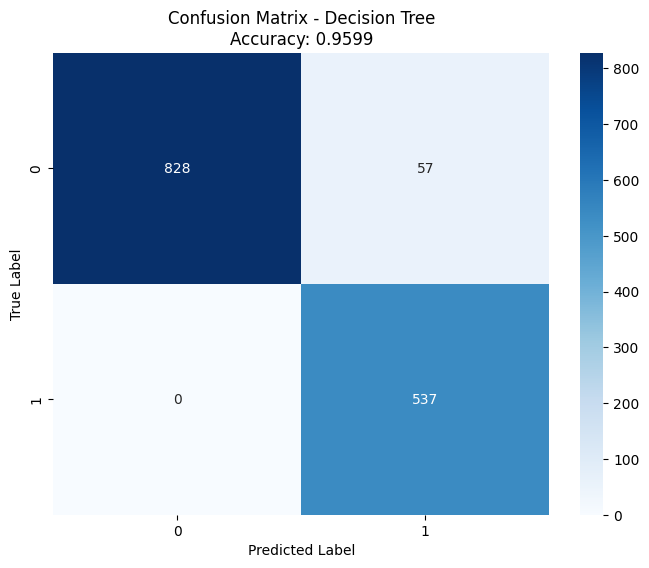


Classification Report for Decision Tree:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       885
         1.0       0.90      1.00      0.95       537

    accuracy                           0.96      1422
   macro avg       0.95      0.97      0.96      1422
weighted avg       0.96      0.96      0.96      1422



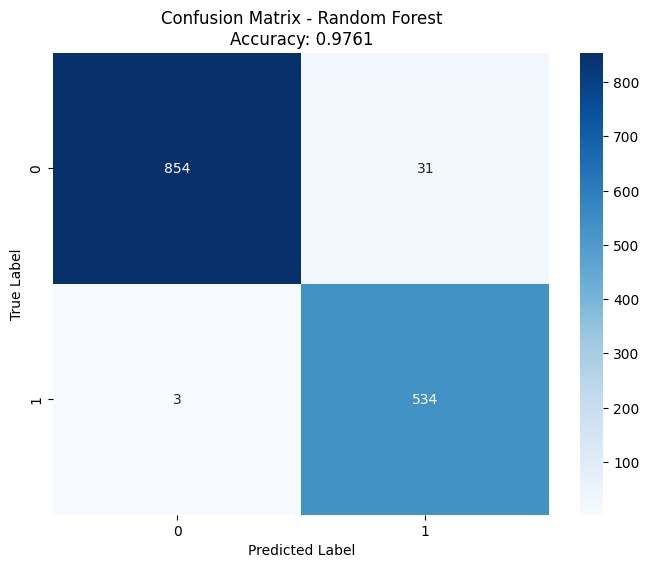


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       885
         1.0       0.95      0.99      0.97       537

    accuracy                           0.98      1422
   macro avg       0.97      0.98      0.97      1422
weighted avg       0.98      0.98      0.98      1422



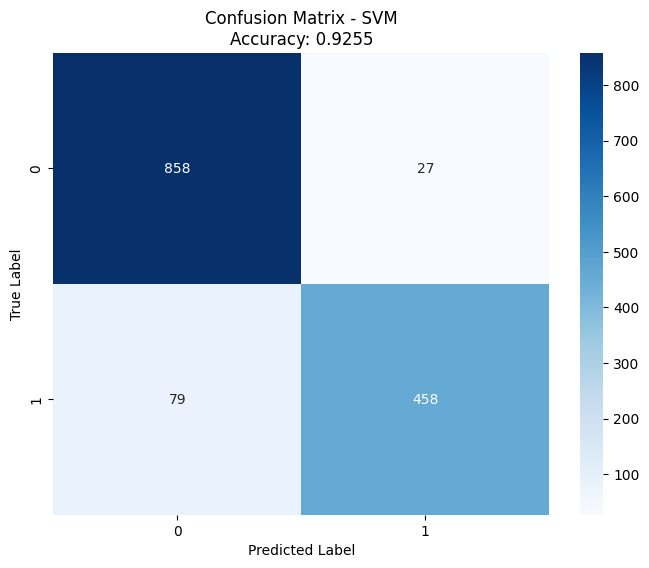


Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       885
         1.0       0.94      0.85      0.90       537

    accuracy                           0.93      1422
   macro avg       0.93      0.91      0.92      1422
weighted avg       0.93      0.93      0.92      1422

Pipeline and model metadata saved successfully. Best model: Random Forest


In [37]:
# Train and evaluate models
results = train_and_evaluate_models(X_train, X_test, Y_train, Y_test)

# Get the best model
best_model_name, _ = get_best_model(results)

# Save the pipeline of the best model
best_pipeline = results[best_model_name]['model']  # Pipeline from results
save_model_components(best_pipeline, best_model_name)
